<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Генерация-и-предобработка" data-toc-modified-id="Генерация-и-предобработка-0.1">Генерация и предобработка</a></span></li></ul></li><li><span><a href="#Подбор-модели-и-гиперпараметров-с-архитектурой-ООП" data-toc-modified-id="Подбор-модели-и-гиперпараметров-с-архитектурой-ООП-1">Подбор модели и гиперпараметров с архитектурой ООП</a></span><ul class="toc-item"><li><span><a href="#Прогноз-на-контрольной-выборке" data-toc-modified-id="Прогноз-на-контрольной-выборке-1.1">Прогноз на контрольной выборке</a></span></li></ul></li><li><span><a href="#Рекурентная-нейронная-сеть---LSTM" data-toc-modified-id="Рекурентная-нейронная-сеть---LSTM-2">Рекурентная нейронная сеть - LSTM</a></span></li></ul></div>

![Image](fon_project.jpg)

# Сравнительный анализ работы алгоритмов ML и DL

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore') 

from IPython.display import display, HTML
pd.options.display.max_columns = None
display(HTML("<style>.container { width:70% !important; }</style>"))

import random
random.seed(42)
%autosave 60

Autosaving every 60 seconds


In [28]:
# загружаем данные
aplan = pd.read_csv(r"C:\Users\123123\Desktop\Выпускной проект\Количество товаров.csv")
aplan.columns = aplan.columns.str.strip('aggr_id_')

# маппим названия фичей
id_features = pd.read_csv(r"C:\Users\123123\Desktop\Выпускной проект\id_features_1.csv")
for i in range(len(id_features)):
    col_id = id_features.iloc[i]['id']
    new_name = id_features.iloc[i]['name']
    aplan.rename(columns={str(col_id): new_name}, inplace=True)
    
# переименовываем фичи
aplan = (aplan.rename(columns={aplan.columns[0]:'target', 
                               'Календарь: Номер часа':'час',
                               'Календарь: День месяца':'день',
                               'Календарь: Номер месяца':'месяц',
                               'Календарь: Агрегация номер года':'год', 
                               }))

### Генерация и предобработка

In [29]:
# лаг на 365 дней
#aplan['lag_365'] = aplan['target'].shift(8760)
#aplan.dropna(inplace=True)

# меняем тип данных
aplan['час'] = aplan['час'].astype(int)
aplan['день'] = aplan['день'].astype(int)
aplan['месяц'] = aplan['месяц'].astype(int)
aplan['год'] = aplan['год'].astype(int)
aplan['год'] = aplan['год'].astype(str)
aplan['месяц'] = aplan['месяц'].astype(str)
aplan['день'] = aplan['день'].astype(str)
aplan['час'] = aplan['час'].astype(str)

# добавляем 0 к значениям
aplan['месяц'] = aplan['месяц'].str.zfill(2)
aplan['день'] = aplan['день'].str.zfill(2)
aplan['час'] = aplan['час'].str.zfill(2)

# создание столбца с датой
aplan['date'] = pd.to_datetime(aplan['год'] + '-' + aplan['месяц'] + '-' + aplan['день'] + ' ' + aplan['час'])

# удаление ненужных символов из столбца 'date'
aplan['date'] = aplan['date'].dt.strftime('%Y-%m-%d %H:%m:%s')
aplan['date'] = pd.to_datetime(aplan['date'])

# возвращаем типы в числовые
aplan['час'] = aplan['час'].astype(int)
aplan['день'] = aplan['день'].astype(int)
aplan['месяц'] = aplan['месяц'].astype(int)
aplan['год'] = aplan['год'].astype(int)

# формируем датафрейм
aplan = aplan.query('date >= "2020-07-01"')

In [30]:
# дашборд
fig = px.line(aplan, x='date', y='target', title='Распределение целевой переменной')
fig.update_xaxes(title_text='Дата', tickformat='%Y-%m-%d')
fig.update_yaxes(title_text='Целевая переменная')
fig.show()

In [7]:
# формируем выборки для обучения и прогноза
train_df = aplan[(aplan['date'] >= '2021-12-01') & (aplan['date'] < '2022-12-01')]
test_df = aplan[(aplan['date'] >= '2022-12-01') & (aplan['date'] < '2023-01-01')]
train_df.drop('date', axis=1, inplace=True)
test_df.drop('date', axis=1, inplace=True)

# признаки и целевая переменная для обучающей и тестовой выборки
X_train = train_df.iloc[:, 1:]  
y_train = train_df['target']
X_test = test_df.iloc[:, 1:]  
y_test = test_df['target']

## Подбор модели и гиперпараметров с архитектурой ООП

In [8]:
%%time
# класс модели с поиском гиперпараметров по сетке
class GridSearchModelTrainer:
    def __init__(self, model, param_grid):
        self.model = model
        self.param_grid = param_grid
        self.grid_search = GridSearchCV(self.model, self.param_grid, cv=5,
                                        scoring='neg_mean_squared_error', n_jobs=-1, verbose=100)
    
    # метод обучения, прогноза и оценки
    def train_evaluate(self, X_train, X_test, y_train, y_test):
        self.grid_search.fit(X_train, y_train)
        best_params = self.grid_search.best_params_
        best_model = self.grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        print("Лучшие параметры:", best_params)
        print('МЕТРИКИ МОДЕЛИ:')
        print('MAE:', round(mean_absolute_error(y_pred, y_test), 5))
        print('MAPE:', round(mean_absolute_percentage_error(y_pred, y_test), 5))
        print('MSE:', round(mean_squared_error(y_pred, y_test), 5))
        print('RMSE:', round(np.sqrt(mean_squared_error(y_pred, y_test))))
        print('R2:', round(r2_score(y_pred, y_test), 5))
        print('---------------------------------------------------------------------------')

# класс CatBoost с сеткой гиперпараметров
class CatBoostModelTrainerGridSearch(GridSearchModelTrainer):
    def __init__(self):
        model = Pipeline(steps=[('forecast', CatBoostRegressor(verbose=0, n_estimators=500))])
        param_grid = {'forecast__learning_rate': [0.1, 0.01], 'forecast__depth': range(1, 8)}
        super().__init__(model, param_grid)

# класс XGBoost с сеткой гиперпараметров
class XGBoostModelTrainerGridSearch(GridSearchModelTrainer):
    def __init__(self):
        model = Pipeline(steps=[('forecast', XGBRegressor())])
        param_grid = {'forecast__learning_rate': [0.1, 0.01], 'forecast__max_depth': range(1, 8)}
        super().__init__(model, param_grid)

# класс GradientBoostingRegressor с сеткой гиперпараметров
class GradientBoostingModelTrainerGridSearch(GridSearchModelTrainer):
    def __init__(self):
        model = Pipeline(steps=[('forecast', GradientBoostingRegressor())])
        param_grid = {'forecast__n_estimators': [100, 300, 500], 'forecast__max_depth': range(1, 8)}
        super().__init__(model, param_grid)

# класс RandomForest с сеткой гиперпараметров
class RandomForestModelTrainerGridSearch(GridSearchModelTrainer):
    def __init__(self):
        model = Pipeline(steps=[('forecast', RandomForestRegressor())])
        param_grid = {'forecast__n_estimators': [100, 300, 500], 'forecast__max_depth': range(1, 8)}
        super().__init__(model, param_grid)        

# модель CatBoost
print("Модель CatBoost:")
catboost_trainer = CatBoostModelTrainerGridSearch()
%time catboost_trainer.train_evaluate(X_train, X_test, y_train, y_test)

# модель XGBoost
print("\nМодель XGBoost:")
xgboost_trainer = XGBoostModelTrainerGridSearch()
%time xgboost_trainer.train_evaluate(X_train, X_test, y_train, y_test)

# модель GradientBoostingRegressor
print("\nМодель GradientBoostingRegressor:")
gradient_boosting_trainer = GradientBoostingModelTrainerGridSearch()
%time gradient_boosting_trainer.train_evaluate(X_train, X_test, y_train, y_test)

# модель RandomForest
print("\nМодель RandomForest:")
random_forest_trainer = RandomForestModelTrainerGridSearch()
%time random_forest_trainer.train_evaluate(X_train, X_test, y_train, y_test)

Модель CatBoost:
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Лучшие параметры: {'forecast__depth': 6, 'forecast__learning_rate': 0.1}
МЕТРИКИ МОДЕЛИ:
MAE: 13.64812
MAPE: 15.07046
MSE: 377.17989
RMSE: 19
R2: 0.95837
---------------------------------------------------------------------------
CPU times: total: 9.72 s
Wall time: 36.3 s

Модель XGBoost:
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Лучшие параметры: {'forecast__learning_rate': 0.1, 'forecast__max_depth': 7}
МЕТРИКИ МОДЕЛИ:
MAE: 14.45363
MAPE: 14.74073
MSE: 459.19475
RMSE: 21
R2: 0.94705
---------------------------------------------------------------------------
CPU times: total: 3.75 s
Wall time: 8.59 s

Модель GradientBoostingRegressor:
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Лучшие параметры: {'forecast__max_depth': 5, 'forecast__n_estimators': 300}
МЕТРИКИ МОДЕЛИ:
MAE: 14.44979
MAPE: 14.63471
MSE: 419.35807
RMSE: 20
R2: 0.95185
----------------------------------------

### Прогноз на контрольной выборке

МЕТРИКИ НА КОНТРОЛЬНОЙ ВЫБОРКЕ:
MAE: 14.78451
MAPE: 18.9119
MSE: 437.77204
RMSE: 21
R2: 0.93968
---------------------------------------------------------------------------


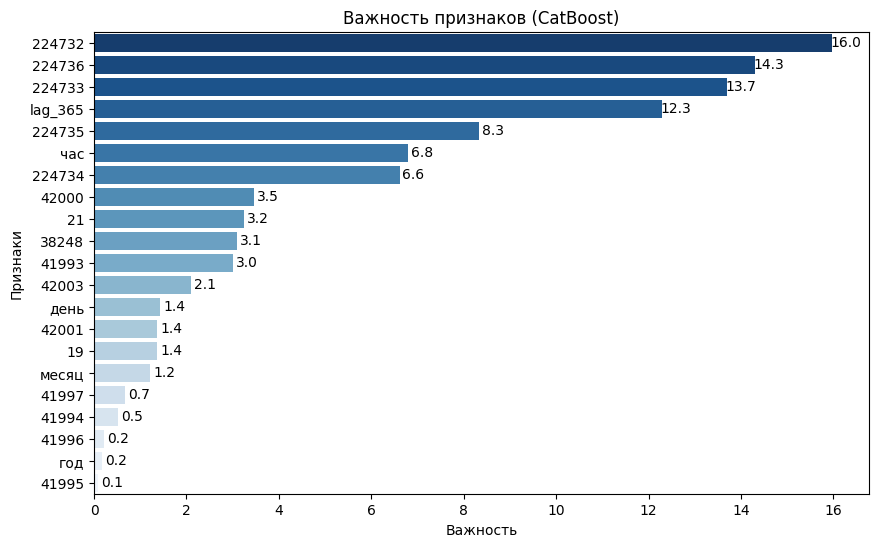

,R2
1,0.128900
2,0.407100
3,0.703500
4,0.785500
5,0.727700
6,0.844800
7,0.925400
8,0.893800
9,0.933300
10,0.956200


In [9]:
# визуализация факт/прогноз лучшей модели - CatBoost
test_df = aplan[(aplan['date'] >= '2023-01-01') & (aplan['date'] < '2023-02-01')]
test_df.drop('date', axis=1, inplace=True)
X_test = test_df.iloc[:, 1:]  
y_test = test_df['target']
y_pred_best_catboost = catboost_trainer.grid_search.best_estimator_.predict(X_test) 
test_df = aplan[(aplan['date'] >= '2023-01-01') & (aplan['date'] < '2023-02-01')]
test_df['y_pred_best_catboost'] = y_pred_best_catboost

print('МЕТРИКИ НА КОНТРОЛЬНОЙ ВЫБОРКЕ:')
print('MAE:', round(mean_absolute_error(y_pred_best_catboost, y_test), 5))
print('MAPE:', round(mean_absolute_percentage_error(y_pred_best_catboost, y_test), 5))
print('MSE:', round(mean_squared_error(y_pred_best_catboost, y_test), 5))
print('RMSE:', round(np.sqrt(mean_squared_error(y_pred_best_catboost, y_test))))
print('R2:', round(r2_score(y_pred_best_catboost, y_test), 5))
print('---------------------------------------------------------------------------')

# дашборд 
fig = px.line(test_df, x=test_df['date'], y=['target', 'y_pred_best_catboost'], 
              labels={'index': 'Дата', 'value': 'Целевая переменная'},
              title='Дашборд факт/прогноз лучшей модели',
              color_discrete_map={'target': 'green', 'y_pred_best_catboost': 'blue'})
fig.show()

# визуализация важности признаков 
if catboost_trainer.grid_search.best_estimator_ is not None:
    feature_importances_catboost = catboost_trainer.grid_search.best_estimator_.named_steps['forecast'].feature_importances_
    features = X_train.columns
    sorted_indices = np.argsort(feature_importances_catboost)[::-1]
    sorted_feature_importances_catboost = feature_importances_catboost[sorted_indices]
    sorted_features = [features[i] for i in sorted_indices]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_feature_importances_catboost, y=sorted_features, palette='Blues_r')
    plt.title('Важность признаков (CatBoost)')
    plt.xlabel('Важность')
    plt.ylabel('Признаки')
    for i, importance in enumerate(sorted_feature_importances_catboost):
        plt.text(importance + 0.3, i, f'{importance:.1f}', ha='center', va='center')
    plt.show()
    
# R2 на каждый день
r2 = []
for i in test_df['день'].unique():
    r2_value = r2_score(test_df[test_df['день'] == i]['target'],
                        test_df[test_df['день'] == i]['y_pred_best_catboost'])
    r2.append(round(r2_value, 4))   
r2_df = pd.DataFrame({'R2': r2})
r2_df.index += 1
def color_r2(val):
        if val >= 0.90:
            color = 'background-color: green; color: white'
        elif 0.9 > val >= 0.8:
            color = 'background-color: yellow; color: black'
        else:
            color = 'background-color: red; color: white'
        return color
r2_styled = r2_df.style.applymap(lambda x: color_r2(x), subset=['R2'])
r2_styled

## Рекурентная нейронная сеть - LSTM

Epoch [10/200], Loss: 8262.7080
Epoch [20/200], Loss: 1815.5078
Epoch [30/200], Loss: 695.8096
Epoch [40/200], Loss: 443.1551
Epoch [50/200], Loss: 377.5092
Epoch [60/200], Loss: 334.7697
Epoch [70/200], Loss: 305.6594
Epoch [80/200], Loss: 284.9842
Epoch [90/200], Loss: 271.6924
Epoch [100/200], Loss: 253.4239
Epoch [110/200], Loss: 243.3251
Epoch [120/200], Loss: 231.2076
Epoch [130/200], Loss: 220.1573
Epoch [140/200], Loss: 212.9492
Epoch [150/200], Loss: 205.1853
Epoch [160/200], Loss: 197.3207
Epoch [170/200], Loss: 188.5317
Epoch [180/200], Loss: 182.9404
Epoch [190/200], Loss: 178.1905


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [200/200], Loss: 170.7550
Test Loss: 978.2004


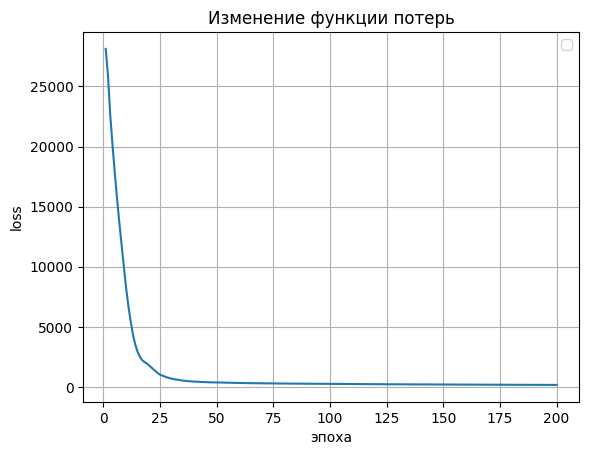

Test MSE: 978.2004
Test R^2: 0.8588
MAE:25.84   MSE:978.20   R2:0.8588 


CPU times: total: 23min 47s
Wall time: 6min 2s


,R2
1,-0.813700
2,-0.159200
3,0.395500
4,0.508700
5,0.567200
6,0.750000
7,0.671600
8,0.578300
9,0.868700
10,0.900600


In [15]:
%%time
# выборки для обучения и прогноза
train_df = aplan[(aplan['date'] >= '2021-01-01') & (aplan['date'] < '2023-01-01')]
test_df = aplan[(aplan['date'] >= '2023-01-01') & (aplan['date'] < '2023-02-01')]
train_df.drop('date', axis=1, inplace=True)
test_df.drop('date', axis=1, inplace=True)
X_train = train_df.iloc[:, 1:]  
y_train = train_df['target'].values  
X_test = test_df.iloc[:, 1:]  
y_test = test_df['target'].values  

# масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# преобразование в тензоры PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32)


# класс для рекурентной сети с LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
    
    # метод прямого прохода
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# функция обучения модели
def train_model(model, X_train, y_train, criterion, optimizer, num_epochs=200, print_every=10):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch+1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return losses

# параметры модели
input_size = 21  
hidden_size = 400  
num_layers = 2  
output_size = 1  
num_epochs = 200
learning_rate = 0.07
dropout_prob = 0.2  

# инициализация модели, функции потерь и оптимизатора
model = LSTM(input_size, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# перенос модели и данных на GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)

# обучение 
losses = train_model(model, X_train, y_train, criterion, optimizer, num_epochs)

# функция для тестирования модели
def test_model(model, X_test, y_test, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs.squeeze(), y_test)
        print(f'Test Loss: {test_loss.item():.4f}')

# тестирование
test_model(model, X_test, y_test, criterion)
        
# визуализация функции потерь
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('эпоха')
plt.ylabel('loss')
plt.title('Изменение функции потерь')
plt.legend()
plt.grid()
plt.show()

# оценка модели 
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    mse = criterion(test_outputs, y_test.view(-1, 1))
    r2 = r2_score(y_test, test_outputs.squeeze().numpy())  
    print(f'Test MSE: {mse.item():.4f}')
    print(f'Test R^2: {r2:.4f}')

test_df = aplan[(aplan['date'] >= '2023-01-01') & (aplan['date'] < '2023-02-01')] 
test_df['test_outputs'] = test_outputs
test_df.loc[(test_df.test_outputs <= 0), ('test_outputs')] = 0

# метрики качества
print('MAE:{:.2f}   MSE:{:.2f}   R2:{:.4f} '.format(mean_absolute_error(test_df['target'], test_outputs), 
                                                        mean_squared_error(test_df['target'], test_outputs), 
                                                        r2_score(test_df['target'], test_outputs)))

# дашборд факт/прогноз
fig = px.line(test_df, x=test_df['date'], y=['target', 'test_outputs'], 
              labels={'index': 'Дата', 'value': 'Целевая переменная'},
              title='Факт/прогноз LSTM',
              color_discrete_map={'target': 'green', 'test_outputs': 'blue'})
fig.show()

# R2 на каждый день с условным форматированием
r2 = []
for i in test_df['день'].unique():
    r2_value = r2_score(test_df[test_df['день'] == i]['target'], test_df[test_df['день'] == i]['test_outputs'])
    r2.append(round(r2_value, 4))  
r2_df = pd.DataFrame({'R2': r2})
r2_df.index += 1
def color_r2(val):
        if val >= 0.90:
            color = 'background-color: green; color: white'
        elif 0.9 > val >= 0.8:
            color = 'background-color: yellow; color: black'
        else:
            color = 'background-color: red; color: white'
        return color
r2_styled = r2_df.style.applymap(lambda x: color_r2(x), subset=['R2'])
r2_styled